In [1]:
import pyspark

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':18})

In [3]:
# Build our Spark Session and Context
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc

(<pyspark.sql.session.SparkSession at 0x7f56ee154dc0>,
 <SparkContext master=local[*] appName=pyspark-shell>)

In [5]:
df = pd.read_csv('data/ml-latest-small/ratings.csv')

In [6]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
spark_df = spark.createDataFrame(df)

In [8]:
spark_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [9]:
spark_df = spark_df.drop('timestamp')
spark_df.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



In [10]:
train, test = spark_df.randomSplit([0.8, 0.2], seed=13)

Max Ratings: 2176
Min Ratings: 11


<AxesSubplot:>

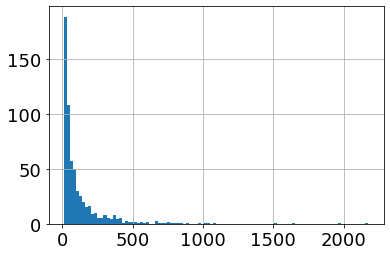

In [59]:
user_count = train.groupBy('userId').count().toPandas()

print('Max Ratings: {}'.format(user_count['count'].max()))
print('Min Ratings: {}'.format(user_count['count'].min()))
user_count['count'].hist(bins = 100)

Max Ratings: 266
Min Ratings: 1


<AxesSubplot:>

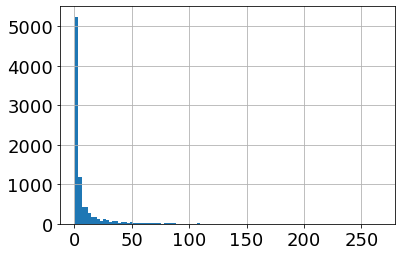

In [60]:
movie_count = train.groupBy('movieId').count().toPandas()

print('Max Ratings: {}'.format(movie_count['count'].max()))
print('Min Ratings: {}'.format(movie_count['count'].min()))
movie_count['count'].hist(bins = 100)

Max Ratings: 522
Min Ratings: 1


<AxesSubplot:>

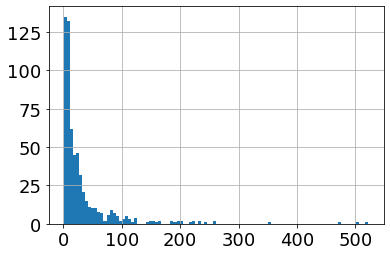

In [61]:
user_count = test.groupBy('userId').count().toPandas()

print('Max Ratings: {}'.format(user_count['count'].max()))
print('Min Ratings: {}'.format(user_count['count'].min()))
user_count['count'].hist(bins = 100)

Max Ratings: 66
Min Ratings: 1


<AxesSubplot:>

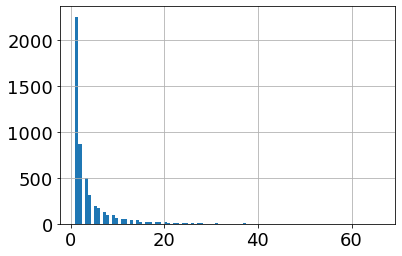

In [62]:
movie_count = test.groupBy('movieId').count().toPandas()

print('Max Ratings: {}'.format(movie_count['count'].max()))
print('Min Ratings: {}'.format(movie_count['count'].min()))
movie_count['count'].hist(bins = 100)

In [12]:
num_users = train.select('userId').distinct().count()
num_movies = train.select('movieId').distinct().count()
num_ratings = train.count()

density = num_ratings/(num_users*num_movies)
density

0.014777169663799843

# Matrix Factorization
## Explicit Model

In [13]:
from pyspark.ml.recommendation import ALS
als_model = ALS(
    itemCol='movieId',
    userCol='userId',
    ratingCol='rating',
    nonnegative=True,
    regParam=0.1,
    rank=10
)


In [14]:
recommender = als_model.fit(train)

In [22]:
one_row_pandas_df = pd.DataFrame({'userId': [1], 'movieId': [100]})
one_row_spark_df = spark.createDataFrame(one_row_pandas_df)
one_row_spark_df.show()

+------+-------+
|userId|movieId|
+------+-------+
|     1|    100|
+------+-------+



In [23]:
# dimentions of the latent features are the 'rank' of the decomposition
recommender.userFactors.show()

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[1.0225443, 0.235...|
| 20|[0.4148577, 1.026...|
| 30|[0.6551465, 0.506...|
| 40|[0.4666952, 0.810...|
| 50|[0.0, 0.63655716,...|
| 60|[0.62279904, 0.33...|
| 70|[0.5038096, 0.462...|
| 80|[0.47049022, 0.39...|
| 90|[0.28540656, 1.09...|
|100|[0.53640085, 0.62...|
|110|[0.61515206, 0.91...|
|120|[0.68671453, 0.18...|
|130|[0.014127094, 0.0...|
|140|[0.6637617, 0.064...|
|150|[0.08861896, 0.20...|
|160|[0.38195333, 0.76...|
|170|[0.7592351, 0.415...|
|180|[0.5442637, 0.385...|
|190|[0.63527346, 0.49...|
|200|[0.1088953, 0.570...|
+---+--------------------+
only showing top 20 rows



In [24]:
recommender.userFactors.show()

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[1.0225443, 0.235...|
| 20|[0.4148577, 1.026...|
| 30|[0.6551465, 0.506...|
| 40|[0.4666952, 0.810...|
| 50|[0.0, 0.63655716,...|
| 60|[0.62279904, 0.33...|
| 70|[0.5038096, 0.462...|
| 80|[0.47049022, 0.39...|
| 90|[0.28540656, 1.09...|
|100|[0.53640085, 0.62...|
|110|[0.61515206, 0.91...|
|120|[0.68671453, 0.18...|
|130|[0.014127094, 0.0...|
|140|[0.6637617, 0.064...|
|150|[0.08861896, 0.20...|
|160|[0.38195333, 0.76...|
|170|[0.7592351, 0.415...|
|180|[0.5442637, 0.385...|
|190|[0.63527346, 0.49...|
|200|[0.1088953, 0.570...|
+---+--------------------+
only showing top 20 rows



In [25]:
user_factor_df = recommender.userFactors.filter('id = 1')
user_factors = user_factor_df.collect()[0]['features']
user_factors

[0.7273737192153931,
 0.5415771007537842,
 0.875194787979126,
 0.719795823097229,
 0.44567784667015076,
 0.9922636151313782,
 0.7763886451721191,
 0.7355836033821106,
 0.6659046411514282,
 0.7427175045013428]

In [26]:
movie_factor_df = recommender.itemFactors.filter('id = 100')
movie_factors = movie_factor_df.collect()[0]['features']
movie_factors

[0.476454496383667,
 0.49925902485847473,
 0.4568241536617279,
 0.14915581047534943,
 0.6184489727020264,
 0.652549147605896,
 0.1625424027442932,
 0.1527702659368515,
 0.7566236257553101,
 0.5023273229598999]

In [27]:
# both are 1,10 arrays, lets dot them
rating = np.dot(user_factors, movie_factors)
rating

3.1627472229456233

In [28]:
onerow_prediction = recommender.transform(one_row_spark_df)
onerow_prediction.show()

+------+-------+----------+
|userId|movieId|prediction|
+------+-------+----------+
|     1|    100| 3.1627474|
+------+-------+----------+



In [29]:
train_predictions = recommender.transform(train)
train_predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   191|    148|   5.0|  4.908964|
|   133|    471|   4.0|  3.185202|
|   597|    471|   2.0| 3.3119514|
|   385|    471|   4.0| 3.3060863|
|   436|    471|   3.0|  3.409234|
|   602|    471|   4.0| 3.1587372|
|    91|    471|   1.0| 2.5467865|
|   409|    471|   3.0|  3.946898|
|   372|    471|   3.0| 2.9764652|
|   599|    471|   2.5|  2.701026|
|   603|    471|   4.0| 3.2168465|
|   182|    471|   4.5| 3.6987925|
|   218|    471|   4.0| 3.4120173|
|   474|    471|   3.0| 3.4757173|
|   500|    471|   1.0| 2.1040268|
|    57|    471|   3.0| 3.5223677|
|   462|    471|   2.5| 2.8084877|
|   387|    471|   3.0|    2.7644|
|   217|    471|   2.0| 2.5580466|
|   555|    471|   3.0| 3.3976388|
+------+-------+------+----------+
only showing top 20 rows



In [30]:
train_predictions.describe().show()

+-------+------------------+-----------------+------------------+------------------+
|summary|            userId|          movieId|            rating|        prediction|
+-------+------------------+-----------------+------------------+------------------+
|  count|             80703|            80703|             80703|             80703|
|   mean| 325.5953186374732|19305.45191628564|3.5007000978897933|3.4093889272295113|
| stddev|182.81617676173943|35417.53366960361|1.0435945664614408|0.7510454566634271|
|    min|                 1|                1|               0.5|        0.32691988|
|    max|               610|           193609|               5.0|         5.3373895|
+-------+------------------+-----------------+------------------+------------------+



In [31]:
test_predictions = recommender.transform(test)
test_predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   610|    471|   4.0| 3.3694572|
|   520|    471|   5.0|  4.027454|
|   136|    471|   4.0| 2.4651508|
|   171|    471|   3.0| 4.4019723|
|   448|    471|   4.0|  3.530367|
|   373|    471|   5.0| 3.9794278|
|   191|    496|   5.0|       NaN|
|   609|    833|   3.0| 1.7047482|
|   307|    833|   1.0| 1.3303909|
|   111|   1088|   3.0|  3.619725|
|    47|   1088|   4.0| 3.0564933|
|   387|   1088|   1.5|  2.766224|
|   381|   1088|   3.5| 3.6588032|
|   583|   1088|   3.5| 3.8819995|
|   594|   1088|   4.5| 3.4906294|
|    10|   1088|   3.0|  3.801182|
|    68|   1088|   3.5| 3.4675171|
|    42|   1088|   3.0| 3.3228178|
|   325|   1238|   4.0| 4.2262864|
|   216|   1238|   5.0| 3.6265635|
+------+-------+------+----------+
only showing top 20 rows



In [32]:
test_predictions.describe().show()

+-------+-----------------+------------------+------------------+----------+
|summary|           userId|           movieId|            rating|prediction|
+-------+-----------------+------------------+------------------+----------+
|  count|            20133|             20133|             20133|     20133|
|   mean|328.2610639248994|19955.773754532358|3.5049918045000745|       NaN|
| stddev|181.8127984879502|35978.358432794026|1.0382666477415254|       NaN|
|    min|                1|                 1|               0.5|0.15266484|
|    max|              610|            193581|               5.0|       NaN|
+-------+-----------------+------------------+------------------+----------+



In [33]:
# Get the top movies for a user 1

recommender.recommendForUserSubset(one_row_spark_df, 10).collect()[0]['recommendations']

[Row(movieId=33649, rating=5.979905605316162),
 Row(movieId=78836, rating=5.798222541809082),
 Row(movieId=86237, rating=5.767210483551025),
 Row(movieId=179135, rating=5.767210483551025),
 Row(movieId=74226, rating=5.767210483551025),
 Row(movieId=7071, rating=5.767210483551025),
 Row(movieId=26073, rating=5.767210483551025),
 Row(movieId=171495, rating=5.767210483551025),
 Row(movieId=84273, rating=5.767210483551025),
 Row(movieId=117531, rating=5.767210483551025)]

## Implicit Recommendations

The basic for the use is that a 1 represents having seen it and 0 not. It can be used in a more complex manor however by including the amount of times the user interacted with the item. Think of a music streaming service if you have listened to a song 10 times it can be inferred you like the song more then one listened to once. Percentages of movie watched can be used as well.

In [34]:
from pyspark.sql.functions import lit
train_w_imprating = train.withColumn('imp_rating', lit(1))
train_w_imprating.show()

+------+-------+------+----------+
|userId|movieId|rating|imp_rating|
+------+-------+------+----------+
|     1|      1|   4.0|         1|
|     1|      6|   4.0|         1|
|     1|     47|   5.0|         1|
|     1|     50|   5.0|         1|
|     1|    101|   5.0|         1|
|     1|    110|   4.0|         1|
|     1|    151|   5.0|         1|
|     1|    157|   5.0|         1|
|     1|    163|   5.0|         1|
|     1|    216|   5.0|         1|
|     1|    231|   5.0|         1|
|     1|    235|   4.0|         1|
|     1|    260|   5.0|         1|
|     1|    296|   3.0|         1|
|     1|    316|   3.0|         1|
|     1|    333|   5.0|         1|
|     1|    349|   4.0|         1|
|     1|    356|   4.0|         1|
|     1|    362|   5.0|         1|
|     1|    367|   4.0|         1|
+------+-------+------+----------+
only showing top 20 rows



In [35]:
als_model_imp = ALS(userCol='userId',
                itemCol='movieId',
                ratingCol='imp_rating',
                implicitPrefs=True,
                nonnegative=True,
                regParam=0.1,
                rank=10
               )

recommender_imp = als_model_imp.fit(train_w_imprating)

In [36]:
# Get the top movies for a user 1

recommender_imp.recommendForUserSubset(one_row_spark_df, 10).collect()[0]['recommendations']

[Row(movieId=2916, rating=0.6959773898124695),
 Row(movieId=1210, rating=0.6778948307037354),
 Row(movieId=1240, rating=0.6711935997009277),
 Row(movieId=1200, rating=0.655117392539978),
 Row(movieId=1214, rating=0.6538501977920532),
 Row(movieId=1036, rating=0.6503915786743164),
 Row(movieId=2985, rating=0.6478635668754578),
 Row(movieId=2628, rating=0.643596887588501),
 Row(movieId=1391, rating=0.6420583128929138),
 Row(movieId=260, rating=0.6395643353462219)]

In [38]:
als_model_imp = ALS(userCol='userId',
                itemCol='movieId',
                ratingCol='rating',
                implicitPrefs=True,
                nonnegative=True,
                regParam=0.1,
                rank=10
               )

recommender_imp = als_model_imp.fit(train_w_imprating)

In [39]:
# Get the top movies for a user 1

recommender_imp.recommendForUserSubset(one_row_spark_df, 10).collect()[0]['recommendations']

[Row(movieId=1214, rating=1.0052897930145264),
 Row(movieId=1200, rating=0.9871896505355835),
 Row(movieId=2916, rating=0.9756388664245605),
 Row(movieId=1210, rating=0.9555643200874329),
 Row(movieId=1196, rating=0.9518911838531494),
 Row(movieId=1387, rating=0.9454148411750793),
 Row(movieId=1036, rating=0.940233588218689),
 Row(movieId=589, rating=0.9360808730125427),
 Row(movieId=1240, rating=0.934161901473999),
 Row(movieId=1270, rating=0.9260388016700745)]

## Evaluation

In [40]:
# Dump the predictions to Pandas DataFrames to make our final calculations easier
test_predictions_df = test_predictions.toPandas()
train_df = train.toPandas()

In [41]:
global_mean = train_df['rating'].mean()
global_mean

3.5007000978897933

In [42]:
# try with global mean fill
test_predictions_df = test_predictions_df.fillna(global_mean)
test_predictions_df.describe()

,userId,movieId,rating,prediction
count,20133.000000,20133.000000,20133.000000,20133.000000
mean,328.261064,19955.773755,3.504992,3.367040
std,181.812798,35978.358433,1.038267,0.707547
min,1.000000,1.000000,0.500000,0.152665
25%,177.000000,1200.000000,3.000000,2.962480
50%,327.000000,3039.000000,3.500000,3.477466
75%,477.000000,8533.000000,4.000000,3.852948
max,610.000000,193581.000000,5.000000,5.716045


In [43]:
def rmse(y, y_hat):
    return np.sqrt(np.mean((y-y_hat)**2))

In [44]:
rmse(test_predictions_df['rating'], test_predictions_df['prediction'])

0.8867660772092508

In [45]:
test_predictions_df['squared_error'] = (test_predictions_df['rating'] - test_predictions_df['prediction'])**2
test_predictions_df.head()

,userId,movieId,rating,prediction,squared_error
0,610,471,4.0,3.369457,0.397584
1,520,471,5.0,4.027454,0.945846
2,136,471,4.0,2.465151,2.355762
3,171,471,3.0,4.401972,1.965526
4,448,471,4.0,3.530367,0.220555


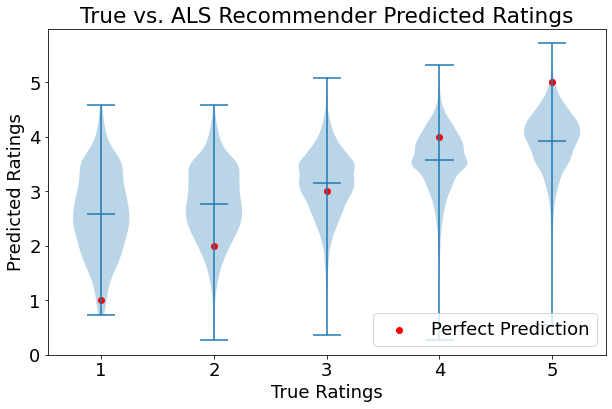

In [46]:
# Create array of predictions for violinplot

data = [test_predictions_df['prediction'][test_predictions_df['rating'] == rating].values for rating in range(1, 6)]
fig, ax = plt.subplots(figsize=(10,6))

ax.violinplot(data, range(1,6), showmeans=True)
ax.scatter(np.arange(1,6,1), np.arange(1,6,1), label='Perfect Prediction', color='red',marker='o')
ax.set_xlabel('True Ratings')
ax.set_ylabel('Predicted Ratings')
ax.set_title('True vs. ALS Recommender Predicted Ratings')
ax.legend(loc='lower right')
plt.show()

In [48]:
als_model_fullreg = ALS(userCol='userId',
                itemCol='movieId',
                ratingCol='rating',
                nonnegative=True,
                regParam=1,
                rank=10
               )

recommender_fullreg = als_model_fullreg.fit(train_w_imprating)

In [49]:
predictions = recommender_fullreg.transform(test)

In [50]:
predictions_df = predictions.toPandas()
predictions_df.head()

,userId,movieId,rating,prediction
0,610,471,4.0,2.638231
1,520,471,5.0,2.740317
2,136,471,4.0,2.417646
3,171,471,3.0,3.156088
4,448,471,4.0,2.166902


In [51]:
predictions_df = predictions_df.fillna(global_mean)
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2
predictions_df.head()

,userId,movieId,rating,prediction,squared_error
0,610,471,4.0,2.638231,1.854415
1,520,471,5.0,2.740317,5.106166
2,136,471,4.0,2.417646,2.503844
3,171,471,3.0,3.156088,0.024364
4,448,471,4.0,2.166902,3.360250


In [52]:
predictions_df.describe() 

,userId,movieId,rating,prediction,squared_error
count,20133.000000,20133.000000,20133.000000,20133.000000,2.013300e+04
mean,328.261064,19955.773755,3.504992,2.568398,1.717002e+00
std,181.812798,35978.358433,1.038267,0.526470,1.748600e+00
min,1.000000,1.000000,0.500000,0.305098,5.130119e-08
25%,177.000000,1200.000000,3.000000,2.226684,3.742951e-01
50%,327.000000,3039.000000,3.500000,2.589708,1.174011e+00
75%,477.000000,8533.000000,4.000000,2.924491,2.506607e+00
max,610.000000,193581.000000,5.000000,4.407802,1.648814e+01


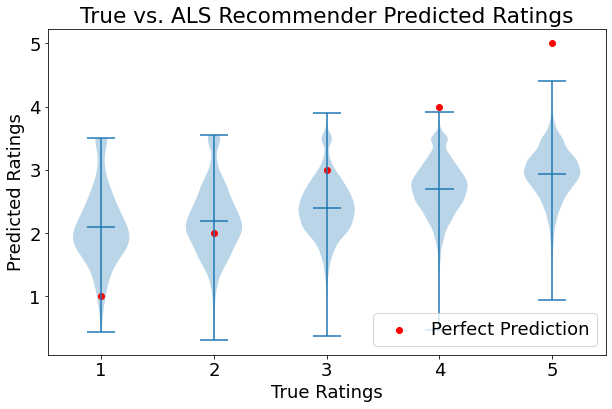

In [53]:
# Create array of predictions for violinplot

data = [predictions_df['prediction'][predictions_df['rating'] == rating].values for rating in range(1, 6)]
fig, ax = plt.subplots(figsize=(10,6))

ax.violinplot(data, range(1,6), showmeans=True)
ax.scatter(np.arange(1,6,1), np.arange(1,6,1), label='Perfect Prediction', color='red',marker='o')
ax.set_xlabel('True Ratings')
ax.set_ylabel('Predicted Ratings')
ax.set_title('True vs. ALS Recommender Predicted Ratings')
ax.legend(loc='lower right')
plt.show()

In [54]:
# increased level of regularization 

In [55]:
def rank_score(df):
    df2 = df.copy()
    df2['rank'] = df2.groupby("userId")["prediction"].rank("dense", ascending=False, na_option='top') -1
    df2 = df2.join(df2.groupby("userId")["rank"].max(), on='user', rsuffix='_max')
    df2['pct_rank'] = df2['rank']/df2['rank_max']
    
    return np.sum(df2['interactions']*df2['pct_rank'])/np.sum(df2['interactions'])
    

In [56]:
implicit_predictions = recommender_imp.transform(test)

In [57]:
implicit_predictions_df = implicit_predictions.toPandas()

In [58]:
implicit_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20133 entries, 0 to 20132
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   userId      20133 non-null  int64  
 1   movieId     20133 non-null  int64  
 2   rating      20133 non-null  float64
 3   prediction  19282 non-null  float32
dtypes: float32(1), float64(1), int64(2)
memory usage: 550.6 KB
